Ok, Mike said I should learn seaborn, Jupyter notebooks and PCA. Why not try to do all three at once? Overload... maybe. But here we go! 

First, let's take care of our imports:

In [146]:
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sb.set_style("darkgrid")

Now lets read our data in and get it into shape a little:

In [147]:
# get variable names
cols = ['sepal length', 'sepal width', 'petal length', 'petal width', 'classification']

# read in iris data set
Z = pd.read_csv('data/iris.data', names=cols)

# set classification column data type to string
Z['classification'] = Z['classification'].astype("string")

# set index by classification for easier access to subsets of the data
Z.set_index('classification', inplace=True, drop=False)
classification = Z.pop('classification')
Z

,sepal length,sepal width,petal length,petal width
classification,,,,
Iris-setosa,5.1,3.5,1.4,0.2
Iris-setosa,4.9,3.0,1.4,0.2
Iris-setosa,4.7,3.2,1.3,0.2
Iris-setosa,4.6,3.1,1.5,0.2
Iris-setosa,5.0,3.6,1.4,0.2
...,...,...,...,...
Iris-virginica,6.7,3.0,5.2,2.3
Iris-virginica,6.3,2.5,5.0,1.9
Iris-virginica,6.5,3.0,5.2,2.0


Mathematically speaking, we want to think of our rows as being samples, and our columns being vectors. In other words each row contains a single sample of each of our four variables. For the same of consistent notation, let's call our variables $x_1, x_2, x_3, x_4$ and our samples $s_1, \dots, s_{150}$. This notation will come in handy later when we are considering the mathematical oprations we must perform on our data.

Next, let's do a little preliminary plot of just two of our variables, petal length and width. This is just for fun and extra practice with seaborn:

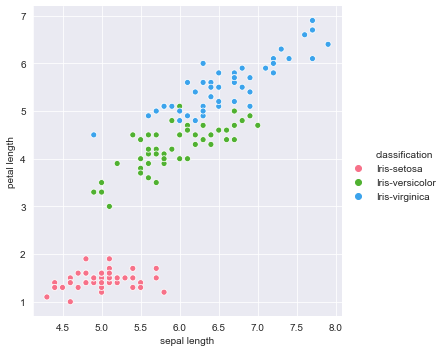

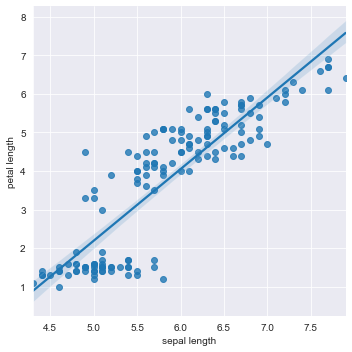

In [157]:
# set figure size:
palette = sb.color_palette("husl", 3)
x, y = ("sepal length", "petal length")
sb.relplot(x=x, y=y, data=Z, hue=classification, palette=palette)
sb.lmplot(x=x, y=y, data=Z, palette=palette)
plt.show()

From our plots we see some correlation between our variables as well as clustering based on the species. Pretty cool!

Next, Let's do PCA on our entire dataset. 

__Step 1:__ We wish to normalize the matrix by calculating the mean of our samples $s_1, \dots s_n$, then subtracting that mean from each sample: 

$$\vec{\mu} = \frac{1}{n}\sum_{i=0}^n s_i = (\mu_{x_1}, ..., \mu_{x_m})$$


In [158]:
mean = df.mean(0)  #find the mean of each column (variable)
df2 = df.apply(lambda x: x - mean, axis = 1)  # subtract the mean sample vector from each row
df2

,classification,petal length,petal width,sepal length,sepal width
classification,,,,,
Iris-setosa,NaN,-2.358667,-0.998667,-0.743333,0.446
Iris-setosa,NaN,-2.358667,-0.998667,-0.943333,-0.054
Iris-setosa,NaN,-2.458667,-0.998667,-1.143333,0.146
Iris-setosa,NaN,-2.258667,-0.998667,-1.243333,0.046
Iris-setosa,NaN,-2.358667,-0.998667,-0.843333,0.546
...,...,...,...,...,...
Iris-virginica,NaN,1.441333,1.101333,0.856667,-0.054
Iris-virginica,NaN,1.241333,0.701333,0.456667,-0.554
Iris-virginica,NaN,1.441333,0.801333,0.656667,-0.054


__Step 2:__ Now we can compute our covariance matrix $S = \frac{1}{n-1}Z^T Z$. Our observation matrix has dimensions $4\times 150$, and therefore when we multiply it by its transpose (which has dimensions $150 \times 4$) we should expect a $4 \times 4$ matrix. 

In [150]:
S = (1/149) * (Z.T @ Z)
S

,sepal length,sepal width,petal length,petal width
sepal length,35.059396,17.926040,23.384228,7.568121
sepal width,17.926040,9.577517,11.234295,3.567315
petal length,23.384228,11.234295,17.335570,5.832013
petal width,7.568121,3.567315,5.832013,2.028859


As predicted we get a 4 by 4 matrix, whose diagonal entries __$S_{ii}$__ will contain the variance of variable $i$, and entries $S_{i,j}$ ($i \not = j)$ will contain the covarience between variable $i$ and $j$. There is a very easy to follow outline of this in the following paper: http://www.math.union.edu/~jaureguj/PCA.pdf

__Step 3:__ As discussed in the above linked paper, we see that the eigenvectors of this matrix will clue us into the directions of variance in our data, and the corresponding egenvalues will tell us the magnitude of that variance. In order to calculate the eigenvalues and eigenvectors, it is useful to convert our data frame into a NumPy ndarray:

In [151]:
S = S.to_numpy()
vals, vects = np.linalg.eig(S)

__Step 4:__ The next step is important, and perhaps easy to forget so close to the end. We must sort our eigenvalues in decreasing order: $$\lambda_1 > \lambda_2 > \dots > \lambda_m$$

and compose a matrix of the associated eigenvectors in that same order: $$P = \bigg[ v_1 | v_2 | \dots | v_m \bigg]$$ 

The magnitude of each eigenvalue is a measure of the variance in our data, and each correspending eigenvector points in the direction of that variation. 

While `numpy.linalg.eig()` does not return our eigenvectors and values in descending order, it does return them such that:

>"such that the column v[:,i] is the eigenvector $v_i$ corresponding to the eigenvalue w[i] $\lambda_i$ ."

Making use of this, we will use numpy.argsort() to get indices to sort our to arrays by:

In [152]:
idx = np.argsort(vals)[::-1] #gives us indices that will sort in descending order
vals = vals[idx]
vects = vects[:, idx]
vals, vects

(array([6.17887959e+01, 2.10807431e+00, 8.07786533e-02, 2.36933669e-02]),
 array([[ 0.75116805,  0.28583096,  0.49942378,  0.32345496],
        [ 0.37978837,  0.54488976, -0.67502499, -0.32124324],
        [ 0.51315094, -0.70889874, -0.05471983, -0.48077482],
        [ 0.16787934, -0.34475845, -0.54029889,  0.74902286]]))

__Step 6:__ To complete our Principle component analysis, we multiply compute $Z' = ZP$. This is the equivilent of rotating our data onto 4 new, orthogonal axes that maximize or variance in decreasing order. 

In [153]:
Z_prime = Z @ vects
Z_prime.reset_index(drop=True, inplace=True)
Z_prime.columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4']
Z_prime

,PCA1,PCA2,PCA3,PCA4
0,5.912204,2.303442,-0.000194,0.001989
1,5.572076,1.973831,0.237434,0.097919
2,5.446485,2.096533,0.008016,0.017057
3,5.436019,1.871681,0.014632,-0.079319
4,5.875066,2.329348,-0.117639,-0.062481
...,...,...,...,...
145,9.226698,-0.929481,-0.206166,0.426142
146,8.566555,-1.036575,0.158640,0.253927
147,9.026101,-0.883220,-0.143961,0.136744
148,9.105660,-0.996221,-0.736832,0.039762


And now we have our PCA table! This completes principle component analysis, but might leave us wondering whether we might not be able to reduce our data down. In order to find out the answe to this question, we want to see how much each principle component contributes to the total variance. Recall that our eigenvalues $\lambda_1 \dots \lambda_4$ represent the amount of variance in our data, where the sum $\sum \lambda_i = T$ gives us total variance. 

If you are inclined to understand the math, think back to the covariance matrix that we calculated and recall that the 4 diagonal elements of that matrix were the variance of each of our 4 variables. It can be proved that the sum of the diagonals (trace, in linear algebra terms) of a matrix is equal to the sum of the eigenvalues of that same matrix:

$$Tr(S) = \sum S_{i,i} = \sum \lambda_i = T$$

Therefore the magnitude of each eigenvalue $\lambda_i$ gives us the fraction of variance that its corresponding principle component contributes: $\frac{\lambda_i}{T}$

Let's find out how much each principle component contributes to the variance in our data:


In [154]:
scree = 100*vals/np.sum(vals)

In other words, we see that first PC contributes to roughly 96 percent of the variation in our data, while the second PC contributes about 3 percent. Combined, they make up for the vast majority of the variation seen in our data. A scree plot visualizes this nicely:

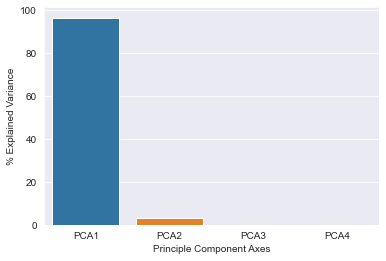

In [155]:
exvar = pd.DataFrame({'Principle Component Axes': ['PCA1', 'PCA2', 'PCA3', 'PCA4'], 
                      '% Explained Variance': scree,
                     })
sb.barplot(x='Principle Component Axes', y='% Explained Variance', data=exvar)

The visualization confirms that PC axes 3 and 4 add very little information, so lets drop them completely and plot our data on just two axes. 

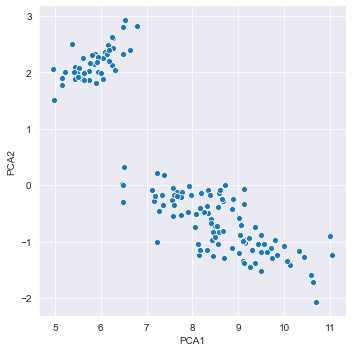

In [156]:
final_frame = Z_prime.loc[:, ['PCA1', 'PCA2']]
sb.relplot(x='PCA1', y='PCA2', data=final_frame)